# Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
!pip install kmodes
from kmodes.kmodes import KModes
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

# Read dataset

In [ ]:
df = pd.read_csv("/content/cardio_train.csv")

In [ ]:
# Checking if the dataset is imported successfully
df.sample(10)

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
48120  68725  19560       1     156    58.0    120     80            1     1   
61513  87826  22008       1     158    71.0    100     70            1     2   
55804  79623  18268       1     165    70.0    120     80            1     1   
34848  49773  20376       1     154    50.0    170    100            1     1   
32256  46068  19584       2     170    98.0    150     90            2     1   
29305  41879  14547       2     182    74.0    140     90            1     1   
4518    6397  19994       1     165    68.0    120     80            1     1   
35393  50558  18350       2     164    68.0    130    100            3     3   
45675  65234  20548       1     158    70.0    120     80            1     1   
64293  91763  16133       1     162   102.0    160    100            1     1   

       smoke  alco  active  cardio  
48120      0     0       0       0  
61513      0     0       1       0  
55804      0     0       1       0  
34848      0     0       1       1  
32256      0     0       1       1  
29305      1     0       1       1  
4518       0     0       0       0  
35393      0     0       1       1  
45675      0     0       1       1  
64293      0     0       0       1

In [ ]:
df = df.drop(columns=['id'])

# **Data Cleaning**
**1) Identifying**

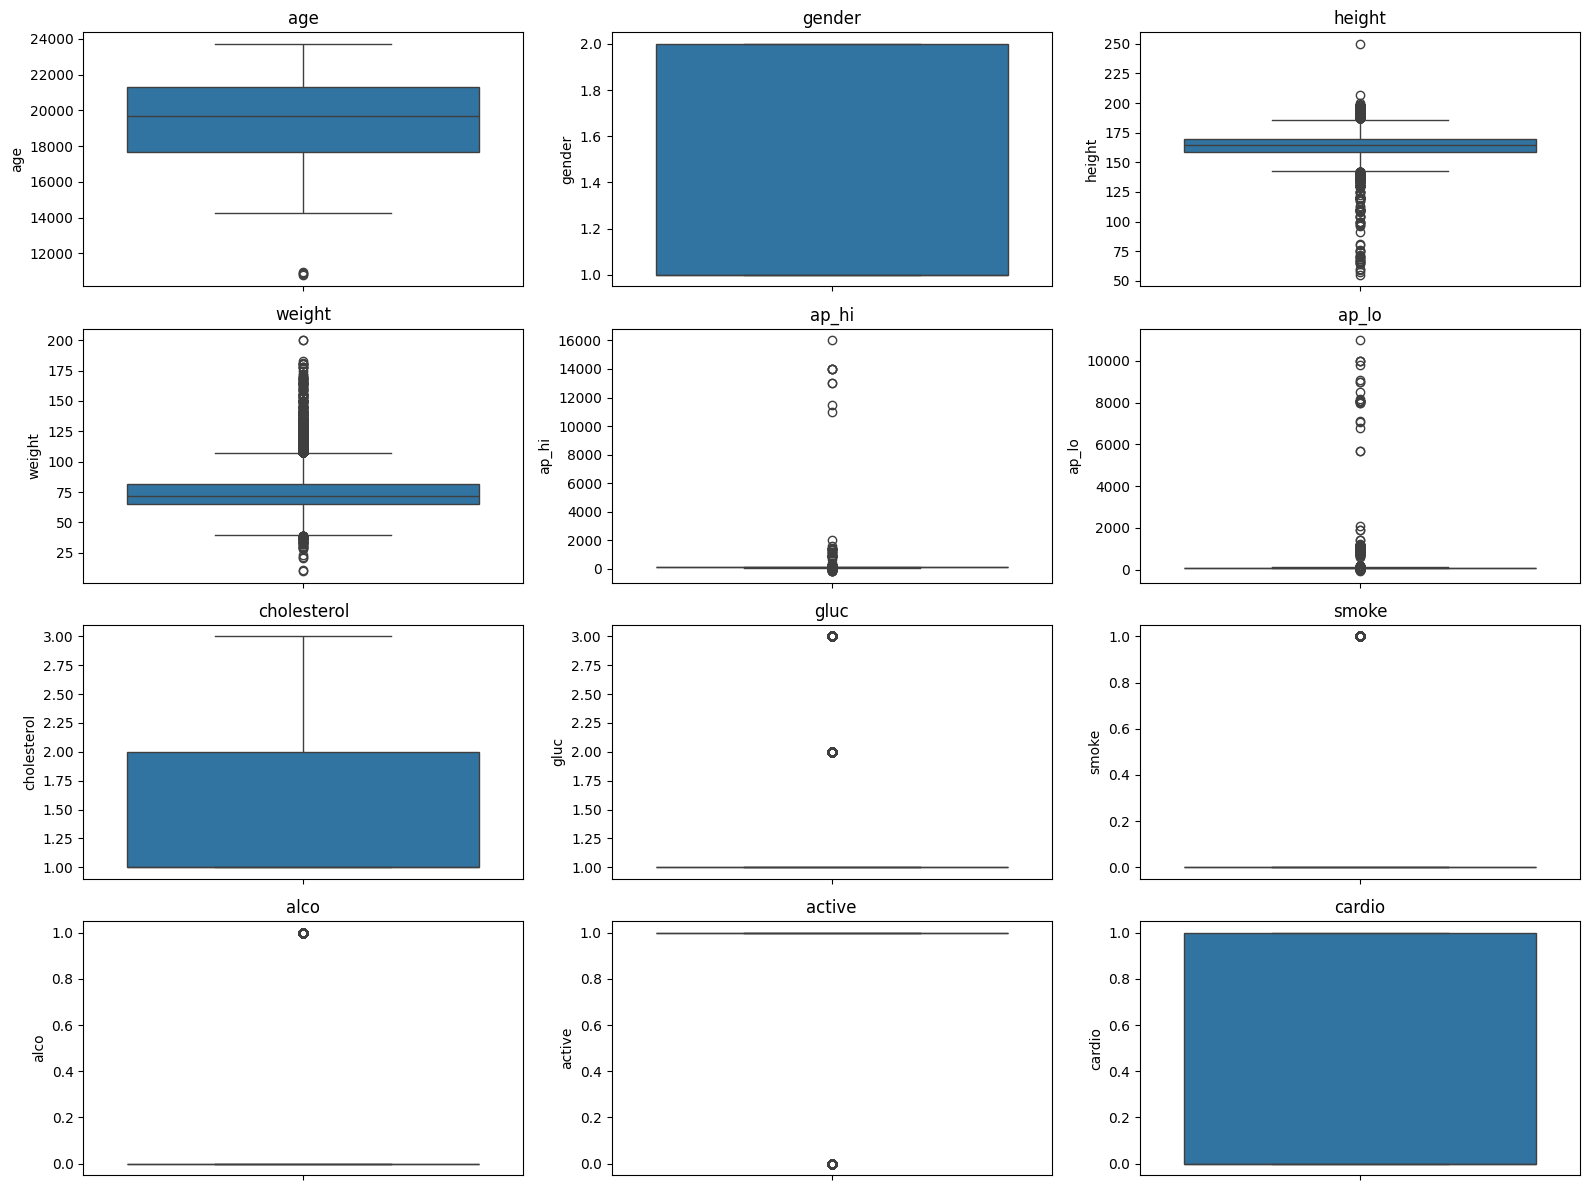

In [ ]:
# Determine number of columns and rows needed
num_cols = len(df.columns)
num_rows = (num_cols - 1) // 12 + 1

# Create subplots
for row in range(num_rows):
    plt.figure(figsize=(16, 12))
    for i, column in enumerate(df.columns[row*12:min((row+1)*12, num_cols)]):
        plt.subplot(4, 3, i + 1)
        sb.boxplot(data=df[column])
        plt.title(column)
    plt.tight_layout()
    plt.show()

* Here, the presence of outliers in the dataset is evident, which are observed in "height", "weight", "ap_hi" and "ap_lo".
* These outliers may have been the result of errors in data entry.
* The removal of these outliers has the potential to improve the performance of our predictive model.

**2) Removal of Outliers**

* Obtain statistical information from the box plot
* First and third quartile gives the box limits
* Inter Quartile Range can be calculated based on the difference between first and third quartile

In [ ]:
df.shape

(70000, 12)

In [ ]:
def statistic_Info(flier):
    Q1 = np.percentile(df[flier],25)
    Q3 = np.percentile(df[flier],75)
    IQR = Q3 - Q1
    lower_Whisker = np.max([df[flier].min(), Q1 - 1.5*IQR])
    upper_Whisker = np.min([df[flier].max(), Q3 + 1.5*IQR])
    return Q1, Q3, IQR, lower_Whisker, upper_Whisker


i. **Height**

In [ ]:
df['height'].describe()

count    70000.000000
mean       164.359229
std          8.210126
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

In [ ]:
q1,q3,k,low,high = statistic_Info("height")
print(q1, q3, k, low, high)

159.0 170.0 11.0 142.5 186.5


In [ ]:
# Finding Outliers
numFliers = df[(df['height'] > high) | (df['height'] < low)].shape[0]
print("No. of fliers: ", numFliers)

# Total Fliers
totalFliers = numFliers
print("Total fliers: ", totalFliers)

# Trim outliers
df = df[(df['height'] <= high) & (df['height'] >= low)]

# Checking if outliers are successfully removed
numFliers = df[(df['height'] > high) | (df['height'] < low)].shape[0]
print("No. of fliers after trimming: ", numFliers)

No. of fliers:  519
Total fliers:  519
No. of fliers after trimming:  0


Number of rows before trimming = 70000

Number of outliers = 519

Available rows = 69481

Total number of outliers  found and removed = 519

ii. **Weight**

In [ ]:
df['weight'].describe()

count    69481.000000
mean        74.152555
std         14.287946
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

In [ ]:
q1,q3,k,low,high = statistic_Info("weight")
print(q1, q3, k, low, high)

65.0 82.0 17.0 39.5 107.5


In [ ]:
# Finding Outliers
numFliers = df[(df['weight'] > high) | (df['weight'] < low)].shape[0]
print("Number of outliers in 'weight' column:", numFliers)

# Total Fliers
totalFliers = totalFliers + numFliers
print("Total number of outliers so far:", totalFliers)

# Checking available rows
print("Number of rows before trimming outliers:", df.shape[0])

# Trimming outliers
df = df[(df['weight'] >= low) & (df['weight'] <= high)]
print("Number of rows after trimming outliers:", df.shape[0])

# Checking if outliers are successfully removed
numFliers = df[(df['weight'] > high) | (df['weight'] < low)].shape[0]
print("Number of outliers in 'weight' column after trimming:", numFliers)

Number of outliers in 'weight' column: 1758
Total number of outliers so far: 2277
Number of rows before trimming outliers: 69481
Number of rows after trimming outliers: 67723
Number of outliers in 'weight' column after trimming: 0


**iii. ap_hi**

In [ ]:
df['ap_hi'].describe()

count    67723.000000
mean       128.585001
std        156.523767
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

In [ ]:
q1,q3,k,low,high = statistic_Info("ap_hi")
print(q1, q3, k, low, high)

120.0 140.0 20.0 90.0 170.0


In [ ]:
# Finding Outliers
numFliers = df[(df['ap_hi'] > high) | (df['ap_hi'] < low)].shape[0]
print("Number of outliers in 'ap_hi' column:", numFliers)

# Total Fliers
totalFliers = totalFliers + numFliers
print("Total number of outliers so far:", totalFliers)

# Checking available rows
print("Number of rows before trimming outliers in 'ap_hi' column:", df['ap_hi'].shape[0])

# Trimming outliers
df = df[(df['ap_hi'] <= high) & (df['ap_hi'] >= low)]
print("Number of rows after trimming outliers in 'ap_hi' column:", df.shape[0])

# Checking if outliers are successfully removed
numFliers = df[(df['ap_hi'] > high) | (df['ap_hi'] < low)].shape[0]
print("Number of outliers in 'ap_hi' column after trimming:", numFliers)

Number of outliers in 'ap_hi' column: 1309
Total number of outliers so far: 3586
Number of rows before trimming outliers in 'ap_hi' column: 67723
Number of rows after trimming outliers in 'ap_hi' column: 66414
Number of outliers in 'ap_hi' column after trimming: 0


**iv. ap_lo**

In [ ]:
df['ap_lo'].describe()

count    66414.000000
mean        94.062065
std        181.418988
min          0.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      10000.000000
Name: ap_lo, dtype: float64

In [ ]:
q1,q3,k,low, high = statistic_Info("ap_lo")
print(q1,q3,k,low, high)

80.0 90.0 10.0 65.0 105.0


In [ ]:
#Finding outliers
numFliers = df[(df['ap_lo']<low) | (df['ap_lo']>high)].shape[0]
print("Number of outliers in 'ap_lo' column:", numFliers)

#total fliers
totalFliers = totalFliers + numFliers
print("Total number of outliers so far:", totalFliers)

# Checking available rows
print("Number of rows before trimming outliers in 'ap_lo' column:", df['ap_lo'].shape[0])

#trimming outliers
df = df[(df['ap_lo']>=low) & (df['ap_lo']<=high)]
print("Number of rows after trimming outliers in 'ap_lo' column:", df.shape[0])

#checking if outliers are successfully removed
numFliers = df[(df['ap_lo']>high) | (df['ap_lo']<low)].shape[0]
print("Number of outliers in 'ap_lo' column after trimming:", numFliers)


Number of outliers in 'ap_lo' column: 3909
Total number of outliers so far: 7495
Number of rows before trimming outliers in 'ap_lo' column: 66414
Number of rows after trimming outliers in 'ap_lo' column: 62505
Number of outliers in 'ap_lo' column after trimming: 0


**Observation**

* Total Number of Rows before trimming outliers = 70,000

* Attributes included = {"height", "weight", "ap_hi", "ap_lo"}

* Total number of outliers detected and removed = 7,495

* Number of available rows (free of outliers) = 62,505

**3.Checking Null Values**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62505 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          62505 non-null  int64  
 1   gender       62505 non-null  int64  
 2   height       62505 non-null  int64  
 3   weight       62505 non-null  float64
 4   ap_hi        62505 non-null  int64  
 5   ap_lo        62505 non-null  int64  
 6   cholesterol  62505 non-null  int64  
 7   gluc         62505 non-null  int64  
 8   smoke        62505 non-null  int64  
 9   alco         62505 non-null  int64  
 10  active       62505 non-null  int64  
 11  cardio       62505 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.2 MB


In [ ]:
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

**4. Checking Missing Data**

In [ ]:
for col in df.columns:
    print(f"Attr : {col}\n",end=" ")
    print(df[col].count())
    print(df[col].unique())
    print("----------------------------------------------")


Attr : age
 62505
[18393 20228 18857 ... 23646 17727 17926]
----------------------------------------------
Attr : gender
 62505
[2 1]
----------------------------------------------
Attr : height
 62505
[168 156 165 169 151 157 178 158 173 181 170 154 162 163 153 159 166 155
 160 175 164 171 152 172 148 179 180 185 167 183 174 176 161 184 182 149
 150 144 147 177 146 186 145 143]
----------------------------------------------
Attr : weight
 62505
[ 62.    85.    64.    82.    67.    93.    95.    71.    80.    60.
  78.    75.    52.    68.    56.    83.    69.    90.    65.    59.
  66.    74.   105.    73.    55.    70.    72.    50.   107.    84.
  77.    79.    58.    97.    76.    53.    57.    49.    94.    92.
  87.   103.    88.   100.    61.    48.    54.    51.    63.    47.
  91.   104.    98.    81.    89.   101.    99.    86.    65.5   96.
  44.    64.8  106.    45.   102.    46.    43.    83.6  106.5   40.
  41.    62.3   89.5   84.6   82.3   67.9   67.5   74.3   60.2   64

**5. Save the dataset in a new CSV File**

In [ ]:
df.to_csv('cleaned_dataset.csv', index=False, encoding='utf-8')

# **Feature Selection & Reduction**

In [ ]:
# Read the cleaned dataset ".csv" file imported to the folder
df = pd.read_csv("cleaned_dataset.csv")
dummy = pd.read_csv("cleaned_dataset.csv")

In [ ]:
# Checking if the dataset is imported successfully
df.head(10)

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  21914       1     151    67.0    120     80            2     2      0   
5  22113       1     157    93.0    130     80            3     1      0   
6  22584       2     178    95.0    130     90            3     3      0   
7  17668       1     158    71.0    110     70            1     1      0   
8  22530       1     169    80.0    120     80            1     1      0   
9  18815       2     173    60.0    120     80            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  
5     0       1       0  
6     0       1       1  
7     0       1       0  
8     0       1       0  
9     0       1       0

**AGE**

In [ ]:
#Converting number of days into years
df["age"] = round(df["age"]/365.0)

In [ ]:
#Calculating interval
min_Age = int(df["age"].min())
max_Age = int(df["age"].max())
print(min_Age, max_Age)

30 65


In [ ]:
#defining interval, bins and labels
interval = 5
age_bins = [30,35,40,45,50,55,60,70]
age_labels = list(i for i in range(len(age_bins)-1))
print(f"{age_bins}\n{age_labels}")

#binning using age_bins and age_labels
# pd.cut(x, bins=[], labels=[], right=True/False, include_lowest=True/False, ...)

df["age"] = pd.cut(df["age"],bins=age_bins, labels=age_labels, include_lowest=True, right=False)
df.head(10)

[30, 35, 40, 45, 50, 55, 60, 70]
[0, 1, 2, 3, 4, 5, 6]


age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   4       2     168    62.0    110     80            1     1      0     0   
1   5       1     156    85.0    140     90            3     1      0     0   
2   4       1     165    64.0    130     70            3     1      0     0   
3   3       2     169    82.0    150    100            1     1      0     0   
4   6       1     151    67.0    120     80            2     2      0     0   
5   6       1     157    93.0    130     80            3     1      0     0   
6   6       2     178    95.0    130     90            3     3      0     0   
7   3       1     158    71.0    110     70            1     1      0     0   
8   6       1     169    80.0    120     80            1     1      0     0   
9   4       2     173    60.0    120     80            1     1      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       0       1  
3       1       1  
4       0       0  
5       1       0  
6       1       1  
7       1       0  
8       1       0  
9       1       0

**BMI**

Body Mass Index is the weight of the bodyh proportion to the square of height, calculated in either metric system or imperical system.


Underweight: BMI less than 18.5

Normal weight: BMI 18.5 to 24.9

Overweight: BMI 25 to 29.9

Obesity Class I (Moderate): BMI 30 to 34.9

Obesity Class II (Severe): BMI 35 to 39.9

Obesity Class III (Very Severe or Morbid Obesity): BMI 40 or greater

In [ ]:
#Converting units of centimetres into metres for attribute "height"
df["height"] = df["height"]/100.0

#calculate BMI

df["BMI"] = round(df["weight"]/(df["height"]**2),1)

df = df.drop(["height", "weight"], axis=1)

In [ ]:
min_bmi = min(df["BMI"])
max_bmi = max(df["BMI"])
print(f"{min_bmi}\t{max_bmi}")

13.5	50.9


In [ ]:
# Defining bins based on the known BMI ranges

bmi_bins = [0,18.5,25,30,35,40,100]
bmi_labels = [i for i in range(len(bmi_bins)-1)]
print(f"{bmi_bins}\n{bmi_labels}")

# Binning
df["BMI"] = pd.cut(df["BMI"],bins=bmi_bins,labels=bmi_labels,right=False,include_lowest=True)
df.head(10)

[0, 18.5, 25, 30, 35, 40, 100]
[0, 1, 2, 3, 4, 5]


age  gender  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio  \
0   4       2    110     80            1     1      0     0       1       0   
1   5       1    140     90            3     1      0     0       1       1   
2   4       1    130     70            3     1      0     0       0       1   
3   3       2    150    100            1     1      0     0       1       1   
4   6       1    120     80            2     2      0     0       0       0   
5   6       1    130     80            3     1      0     0       1       0   
6   6       2    130     90            3     3      0     0       1       1   
7   3       1    110     70            1     1      0     0       1       0   
8   6       1    120     80            1     1      0     0       1       0   
9   4       2    120     80            1     1      0     0       1       0   

  BMI  
0   1  
1   3  
2   1  
3   2  
4   2  
5   4  
6   3  
7   2  
8   2  
9   1

**MAP**

Mean Arterial Pressure defines the average blood pressure of a person in one cardiac cycle.

HypoTension Crisis : Below 70

HypoTension : 70 to 80

Normal : 80 to 90

Elevated/Pre HyperTension: 90 to 100

Hyper Tension Stage I: 100 to 110

Hyper Tension StageII: 110 to 120

Hyper Tension Crisis : Above 120

In [ ]:
df["MAP"] = round(((2*df["ap_lo"])+df["ap_hi"])/3)
df = df.drop(["ap_lo","ap_hi"],axis=1)
df.head(10)

age  gender  cholesterol  gluc  smoke  alco  active  cardio BMI    MAP
0   4       2            1     1      0     0       1       0   1   90.0
1   5       1            3     1      0     0       1       1   3  107.0
2   4       1            3     1      0     0       0       1   1   90.0
3   3       2            1     1      0     0       1       1   2  117.0
4   6       1            2     2      0     0       0       0   2   93.0
5   6       1            3     1      0     0       1       0   4   97.0
6   6       2            3     3      0     0       1       1   3  103.0
7   3       1            1     1      0     0       1       0   2   83.0
8   6       1            1     1      0     0       1       0   2   93.0
9   4       2            1     1      0     0       1       0   1   93.0

In [ ]:
min_map = min(df["MAP"])
max_map = max(df["MAP"])
print(f"{min_map}\t{max_map}")

73.0	126.0


In [ ]:
# Defining bin values based on the above criteria
map_bins = [0,70,80,90,100,110,140]
map_labels = list(i for i in range(len(map_bins)-1))
print(f"{map_bins}\n{map_labels}")

#binning
df["MAP"] = pd.cut(df['MAP'],bins=map_bins,labels=map_labels,include_lowest=True,right=False)
df.head(10)

[0, 70, 80, 90, 100, 110, 140]
[0, 1, 2, 3, 4, 5]


age  gender  cholesterol  gluc  smoke  alco  active  cardio BMI MAP
0   4       2            1     1      0     0       1       0   1   3
1   5       1            3     1      0     0       1       1   3   4
2   4       1            3     1      0     0       0       1   1   3
3   3       2            1     1      0     0       1       1   2   5
4   6       1            2     2      0     0       0       0   2   3
5   6       1            3     1      0     0       1       0   4   3
6   6       2            3     3      0     0       1       1   3   4
7   3       1            1     1      0     0       1       0   2   2
8   6       1            1     1      0     0       1       0   2   3
9   4       2            1     1      0     0       1       0   1   3

**Checking MISSING Data**

In [ ]:
df.isna().sum()

age            0
gender         0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
BMI            0
MAP            0
dtype: int64

**Data Transformation**

In [ ]:
df.describe()

gender   cholesterol          gluc         smoke          alco  \
count  62505.000000  62505.000000  62505.000000  62505.000000  62505.000000   
mean       1.348564      1.357699      1.220638      0.086345      0.052172   
std        0.476519      0.675192      0.567590      0.280875      0.222375   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%        1.000000      1.000000      1.000000      0.000000      0.000000   
50%        1.000000      1.000000      1.000000      0.000000      0.000000   
75%        2.000000      1.000000      1.000000      0.000000      0.000000   
max        2.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio  
count  62505.000000  62505.000000  
mean       0.804320      0.493880  
std        0.396727      0.499967  
min        0.000000      0.000000  
25%        1.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      1.000000  
max        1.000000      1.000000

In [ ]:
labelEncoder = preprocessing.LabelEncoder()
df = df.apply(labelEncoder.fit_transform)
for col in df.columns:
    print(f"Attr : {col}\n",end=" ")
    print(df[col].count())
    print(df[col].unique())
    print("----------------------------------------------")

Attr : age
 62505
[4 5 3 6 2 1 0]
----------------------------------------------
Attr : gender
 62505
[1 0]
----------------------------------------------
Attr : cholesterol
 62505
[0 2 1]
----------------------------------------------
Attr : gluc
 62505
[0 1 2]
----------------------------------------------
Attr : smoke
 62505
[0 1]
----------------------------------------------
Attr : alco
 62505
[0 1]
----------------------------------------------
Attr : active
 62505
[1 0]
----------------------------------------------
Attr : cardio
 62505
[0 1]
----------------------------------------------
Attr : BMI
 62505
[1 3 2 4 5 0]
----------------------------------------------
Attr : MAP
 62505
[2 3 4 1 0]
----------------------------------------------


In [ ]:
# Identify rows containing NaN values
nan_rows = df[df.isna().any(axis=1)]

# Print entire rows containing NaN values
for index, row in nan_rows.iterrows():
    print(row)
    print("-----------------------------------------------------------------")

In [ ]:
df.describe()

age        gender   cholesterol          gluc         smoke  \
count  62505.000000  62505.000000  62505.000000  62505.000000  62505.000000   
mean       4.279930      0.348564      0.357699      0.220638      0.086345   
std        1.334118      0.476519      0.675192      0.567590      0.280875   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.000000      0.000000      0.000000      0.000000      0.000000   
75%        5.000000      1.000000      0.000000      0.000000      0.000000   
max        6.000000      1.000000      2.000000      2.000000      1.000000   

               alco        active        cardio           BMI           MAP  
count  62505.000000  62505.000000  62505.000000  62505.000000  62505.000000  
mean       0.052172      0.804320      0.493880      1.938981      2.280426  
std        0.222375      0.396727      0.499967      0.944946      0.869148  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.000000      1.000000      0.000000      1.000000      2.000000  
50%        0.000000      1.000000      0.000000      2.000000      2.000000  
75%        0.000000      1.000000      1.000000      2.000000      3.000000  
max        1.000000      1.000000      1.000000      5.000000      4.000000

**Save the dataset in new csv file**

In [ ]:
df.to_csv('transformed_Dataset.csv', index=False, encoding='utf-8')

# **Clustering and Modeling**

In [ ]:
# Read the transformed dataset ".csv" file imported to the folder
df = pd.read_csv("/content/transformed_Dataset.csv")

**Elbow Curve Method**

In [ ]:
cost = []
num_clusters = range(1,6) # 1 to 5
for i in list(num_clusters):
    kmode = KModes(n_clusters=i, init = "Huang", n_init = 5, verbose=0,random_state=1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)

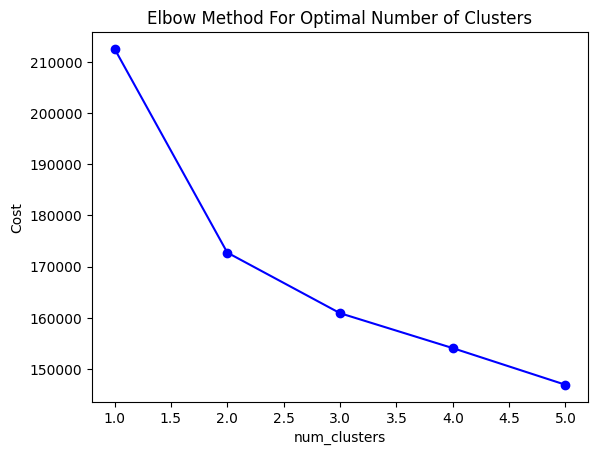

In [ ]:
plt.plot(num_clusters, cost, 'bo-')
plt.xlabel('num_clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

Optimal Number of clusters: 2

**K Modes Clustering**

In [ ]:
km = KModes(n_clusters=2, init = "Huang", n_init = 5,random_state=1)
clusters = km.fit_predict(df)

**Correlation Matrix**

In [ ]:
df.insert(0,"clusters",clusters,True)
df.head(10)

clusters  age  gender  cholesterol  gluc  smoke  alco  active  cardio  BMI  \
0         0    4       1            0     0      0     0       1       0    1   
1         1    5       0            2     0      0     0       1       1    3   
2         0    4       0            2     0      0     0       0       1    1   
3         1    3       1            0     0      0     0       1       1    2   
4         0    6       0            1     1      0     0       0       0    2   
5         0    6       0            2     0      0     0       1       0    4   
6         1    6       1            2     2      0     0       1       1    3   
7         0    3       0            0     0      0     0       1       0    2   
8         0    6       0            0     0      0     0       1       0    2   
9         0    4       1            0     0      0     0       1       0    1   

   MAP  
0    2  
1    3  
2    2  
3    4  
4    2  
5    2  
6    3  
7    1  
8    2  
9    2

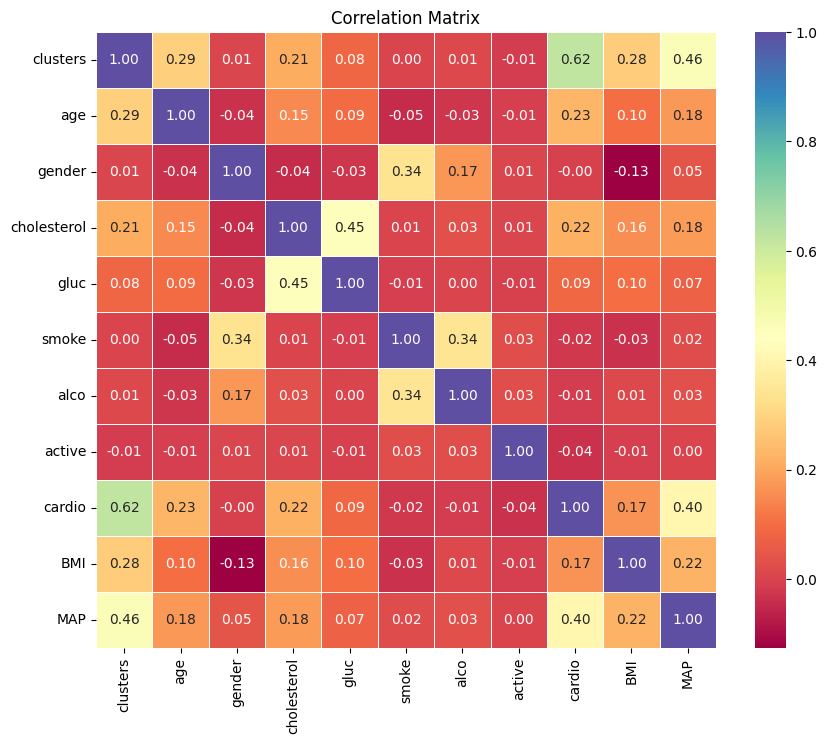

In [ ]:
plt.figure(figsize=(10, 8))

# Draw correlation matrix
sb.heatmap(df.corr(), annot=True, cmap='Spectral', fmt=".2f", linewidths=.5)

# Show the figure
plt.title('Correlation Matrix')
plt.show()

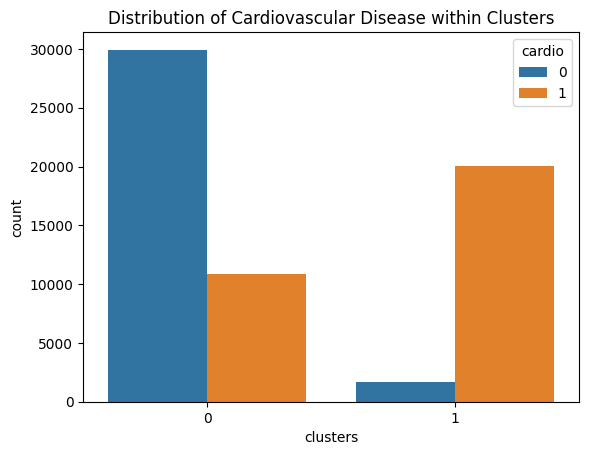

In [ ]:
sb.countplot(x='clusters', hue='cardio', data=df)
plt.title('Distribution of Cardiovascular Disease within Clusters')
plt.show()

**TRAINING**

In [ ]:
x = df.drop(['cardio','gender','alco'], axis=1)
y = df['cardio']

x.head()

clusters  age  cholesterol  gluc  smoke  active  BMI  MAP
0         0    4            0     0      0       1    1    2
1         1    5            2     0      0       1    3    3
2         0    4            2     0      0       0    1    2
3         1    3            0     0      0       1    2    4
4         0    6            1     1      0       0    2    2

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=1)
x_train_xg,x_test_xg,y_train_xg,y_test_xg=train_test_split(x,y,test_size=0.20,random_state=1)
x_train_mlp,x_test_mlp,y_train_mlp,y_test_mlp=train_test_split(x,y,test_size=0.20,random_state=1)
x_train_rf,x_test_rf,y_train_rf,y_test_rf=train_test_split(x,y,test_size=0.20,random_state=1)
x_train_dt,x_test_dt,y_train_dt,y_test_dt=train_test_split(x,y,test_size=0.20,random_state=1)

#**MODELING**

**RF**

In [ ]:
# Define features (x) and target (y)
x = df.drop(['cardio', 'gender', 'alco'], axis=1)
y = df['cardio']

# Random Forest model
rf_model = RandomForestClassifier(random_state=1)

# Fit the model
rf_model.fit(x_train, y_train)

# Make predictions
rf_pred = rf_model.predict(x_test)

# Accuracy
rf_accuracy = metrics.accuracy_score(y_test, rf_pred) * 100
print(f"Accuracy without CV: {rf_accuracy:.2f}")

# Define a simplified parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None],
}

# Create grid search for Random Forest
rf_gridsearch = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search for Random Forest
rf_gridsearch.fit(x_train, y_train)

Accuracy without CV: 84.13


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'max_features': ['sqrt', None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [ ]:
best_params = rf_gridsearch.best_params_
best_estimator = rf_gridsearch.best_estimator_

print(f"Best Parameters : {best_params}")
print(f"Best Estimator  : {best_estimator}")

Best Parameters : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Estimator  : RandomForestClassifier(max_depth=10, max_features=None, min_samples_split=5,
                       random_state=1)


In [ ]:
rf_pred_CV = best_estimator.predict(x_test_rf)

In [ ]:
rf_accuracy_cv = metrics.accuracy_score(y_test_rf, rf_pred_CV)*100
print(f"Best Accuracy: {rf_accuracy_cv:.2f}")

Best Accuracy: 84.47


In [ ]:
print(f"Random Forest accuracy without CV : {rf_accuracy:.2f}")
print(f"Random Forest accuracy with CV    : {rf_accuracy_cv:.2f}")

Random Forest accuracy without CV : 84.13
Random Forest accuracy with CV    : 84.47


In [ ]:
classification_report_str = classification_report(y_test, rf_pred_CV, digits=4)

print("Classification Report for RF with CV:\n", classification_report_str)

Classification Report for RF with CV:
               precision    recall  f1-score   support

           0     0.8043    0.9101    0.8539      6237
           1     0.8970    0.7795    0.8341      6264

    accuracy                         0.8447     12501
   macro avg     0.8506    0.8448    0.8440     12501
weighted avg     0.8507    0.8447    0.8440     12501



# **MLP**

In [ ]:
#mlp

# build MLP model
mlpModel = MLPClassifier(random_state=1)

# Fit the model
mlpModel.fit(x_train_mlp, y_train_mlp)

# Make predictions
mlp_pred = mlpModel.predict(x_test_mlp)

# accuracy
mlp_accuracy = metrics.accuracy_score(y_test_mlp, mlp_pred)*100
print(f"Accuracy without CV: {mlp_accuracy:.2f}")

Accuracy without CV: 84.19


In [ ]:
# Best parameters for MLP
mlp_best_params = {
    'activation': ['tanh'],
    'alpha': [0.01],
    'hidden_layer_sizes': [(50, 50)],
    'max_iter': [300],
    'solver': ['adam'],
}

# Create grid search
mlp_gridsearch = GridSearchCV(estimator=mlpModel, param_grid=mlp_best_params, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
mlp_gridsearch.fit(x_train_mlp, y_train_mlp)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=1), n_jobs=-1,
             param_grid={'activation': ['tanh'], 'alpha': [0.01],
                         'hidden_layer_sizes': [(50, 50)], 'max_iter': [300],
                         'solver': ['adam']},
             scoring='accuracy')

In [ ]:
# mlp_best_params = mlp_gridsearch.best_params_
mlp_best_estimator = mlp_gridsearch.best_estimator_

print(f"Best Parameters : {mlp_best_params}")
print(f"Best Estimator  : {mlp_best_estimator}")

Best Parameters : {'activation': ['tanh'], 'alpha': [0.01], 'hidden_layer_sizes': [(50, 50)], 'max_iter': [300], 'solver': ['adam']}
Best Estimator  : MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              max_iter=300, random_state=1)


In [ ]:
mlp_pred_CV = mlp_best_estimator.predict(x_test_mlp)

In [ ]:
mlp_accuracy_cv = metrics.accuracy_score(y_test_mlp, mlp_pred_CV)*100
print(f"Best Accuracy: {mlp_accuracy_cv:.2f}")

Best Accuracy: 84.23


In [ ]:
print(f"MLP accuracy without CV : {mlp_accuracy:.2f}")
print(f"MLP accuracy with CV    : {mlp_accuracy_cv:.2f}")

MLP accuracy without CV : 84.19
MLP accuracy with CV    : 84.23


In [ ]:
classification_report_str = classification_report(y_test, mlp_pred_CV, digits=4)

print("Classification Report for MLP with CV:\n", classification_report_str)

Classification Report for MLP with CV:
               precision    recall  f1-score   support

           0     0.7966    0.9186    0.8532      6237
           1     0.9043    0.7664    0.8297      6264

    accuracy                         0.8423     12501
   macro avg     0.8504    0.8425    0.8415     12501
weighted avg     0.8506    0.8423    0.8414     12501



# **DT**

In [ ]:
#dt

# build MLP model
dtModel = DecisionTreeClassifier(random_state=1)

# Fit the model
dtModel.fit(x_train_dt, y_train_dt)

# Make predictions
dt_pred = dtModel.predict(x_test_dt)

# accuracy
dt_accuracy = metrics.accuracy_score(y_test_dt, dt_pred)*100
print(f"Accuracy without CV: {dt_accuracy:.2f}")

Accuracy without CV: 83.93


In [ ]:
# Best parameters for dt
dt_best_params = {
    'criterion': ['entropy'],
    'max_depth': [6],
   # 'n_estimators': [100],
    #'subsample': [0.8],
    #'colsample_bytree': [0.8],

}

# Create grid search
dt_gridsearch = GridSearchCV(estimator=dtModel, param_grid=dt_best_params, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
dt_gridsearch.fit(x_train_dt, y_train_dt)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [6]},
             scoring='accuracy')

In [ ]:
dt_best_estimator = dt_gridsearch.best_estimator_

print(f"Best Parameters : {dt_best_params}")
print(f"Best Estimator  : {dt_best_estimator}")

Best Parameters : {'criterion': ['entropy'], 'max_depth': [6]}
Best Estimator  : DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)


In [ ]:
dt_pred_CV = dt_best_estimator.predict(x_test_dt)

In [ ]:
dt_accuracy_cv = metrics.accuracy_score(y_test_dt, dt_pred_CV)*100
print(f"Best Accuracy with cv: {dt_accuracy_cv:.2f}")

Best Accuracy with cv: 82.69


# **XGBoost**

In [ ]:
#xgboost
xgbmodel = XGBClassifier(random_state=1)


# Fit the model
xgbmodel.fit(x_train_xg, y_train_xg)

# Make predictions
xgbpred = xgbmodel.predict(x_test_xg)

# accuracy
xgbaccuracy = metrics.accuracy_score(y_test_xg, xgbpred)*100
print(f"Accuracy without CV: {xgbaccuracy:.2f}")


Accuracy without CV: 84.46


In [ ]:
print(x_train_xg.shape, y_train_xg.shape)

(50004, 8) (50004,)


In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],

}

best_xgbparam = {
    'learning_rate': [0.1],
    'max_depth': [3],
    'n_estimators': [100],
    'subsample': [0.8],
    'colsample_bytree': [0.8],

}

grid_search = GridSearchCV(estimator=xgbmodel, param_grid=best_xgbparam, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_xg, y_train_xg)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.1],
                         'max_depth': [3], 'n_estimators': [100],
                         'subsample': [0.8]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best parameters: {best_params}')
print(f"Best Estimator  : {best_model}")

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Estimator  : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)


In [ ]:
xgb_pred_CV = best_model.predict(x_test_xg)

In [ ]:
xgb_accuracy_cv = metrics.accuracy_score(y_test_xg, xgb_pred_CV)*100
print(f"Best Accuracy with CV: {xgb_accuracy_cv:.2f}")

Best Accuracy with CV: 83.31


# **Performance Metric Evaluation**

**Accuracy without CV**

In [ ]:
print(f"RF accuracy without CV : {rf_accuracy:.2f}")
print(f"mlp accuracy without CV : {mlp_accuracy:.2f}")
print(f"Dt accuracy without CV : {dt_accuracy:.2f}")
print(f"XGB accuracy without CV: {xgbaccuracy:.2f}")


RF accuracy without CV : 84.13
mlp accuracy without CV : 84.19
Dt accuracy without CV : 83.93
XGB accuracy without CV: 84.46
RF accuracy with CV    : 84.47
mlp accuracy with CV    : 84.23
Dt accuracy with CV    : 82.69
XGB accuracy with CV    : 83.31


**AUC Score without CV**

In [ ]:
# Predict probabilities
rf_probs = rf_model.predict_proba(x_test)[:, 1]
dt_probs = dtModel.predict_proba(x_test)[:, 1]
mlp_probs = mlpModel.predict_proba(x_test)[:, 1]
xgb_probs = xgbmodel.predict_proba(x_test)[:, 1]

# Calculate AUC scores
rf_auc = roc_auc_score(y_test_rf, rf_probs)
dt_auc = roc_auc_score(y_test_dt, dt_probs)
mlp_auc = roc_auc_score(y_test_mlp, mlp_probs)
xgb_auc = roc_auc_score(y_test_xg, xgb_probs)

# Print AUC scores
print("Random Forest AUC:", round(rf_auc,2))
print("Decision Tree AUC:", round(dt_auc,2))
print("Multi-Layer Perceptron AUC:", round(mlp_auc,2))
print("XGBoost AUC:", round(xgb_auc,2))

Random Forest AUC: 0.92
Decision Tree AUC: 0.92
Multi-Layer Perceptron AUC: 0.92
XGBoost AUC: 0.93


**F1 Score without CV**

In [ ]:
rf_f1 = f1_score(y_test_rf, rf_pred)
dt_f1 = f1_score(y_test_dt, dt_pred)
mlp_f1 = f1_score(y_test_mlp, mlp_pred)
xgb_f1 = f1_score(y_test_xg, xgbpred)

# Print F1 score, recall, and precision
print("Random Forest F1 score without CV:", round(rf_f1*100,2))
print("Decision Tree F1 score without CV:", round(dt_f1*100,2))
print("Multi-Layer Perceptron F1 score without CV:", round(mlp_f1*100,2))
print("XGBoost F1 score without CV:", round(xgb_f1*100,2))

Random Forest F1 score without CV: 83.21
Decision Tree F1 score without CV: 82.92
Multi-Layer Perceptron F1 score without CV: 83.28
XGBoost F1 score without CV: 83.43


**Recall without CV**

In [ ]:
rf_recall = recall_score(y_test_rf, rf_pred)
dt_recall = recall_score(y_test_dt, dt_pred)
mlp_recall = recall_score(y_test_mlp, mlp_pred)
xgb_recall = recall_score(y_test_xg, xgbpred)

print("Random Forest Recall without CV:", round(rf_recall*100,2))
print("Decision Tree Recall without CV:", round(dt_recall*100,2))
print("Multi-Layer Perceptron Recall without CV:", round(mlp_recall*100,2))
print("XGBoost Recall without CV:", round(xgb_recall*100,2))

Random Forest Recall without CV: 78.48
Decision Tree Recall without CV: 77.83
Multi-Layer Perceptron Recall without CV: 78.58
XGBoost Recall: 78.11


**Precision without CV**

In [ ]:
rf_precision = precision_score(y_test_rf, rf_pred)
dt_precision = precision_score(y_test_dt, dt_pred)
mlp_precision = precision_score(y_test_mlp, mlp_pred)
xgb_precision = precision_score(y_test_xg, xgbpred)

print("Random Forest Precision without CV:", round(rf_precision*100,2))
print("Decision Tree Precision without CV:", round(dt_precision*100,2))
print("Multi-Layer Perceptron Precision without CV:", round(mlp_precision*100,2))
print("XGBoost Precision: without CV", round(xgb_precision*100,2))

Random Forest Precision without CV: 88.54
Decision Tree Precision without CV: 88.72
Multi-Layer Perceptron Precision without CV: 88.59
XGBoost Precision: without CV 89.53


**Accuracy with CV**

In [ ]:
print(f"RF accuracy with CV    : {rf_accuracy_cv:.2f}")
print(f"mlp accuracy with CV    : {mlp_accuracy_cv:.2f}")
print(f"Dt accuracy with CV    : {dt_accuracy_cv:.2f}")
print(f"XGB accuracy with CV    : {xgb_accuracy_cv:.2f}")

RF accuracy with CV    : 84.47
mlp accuracy with CV    : 84.23
Dt accuracy with CV    : 82.69
XGB accuracy with CV    : 83.31


**F1 Score with CV**

In [ ]:
rf_f1_cv = cross_val_score(rf_model, x, y, cv=5, scoring='f1').mean()
dt_f1_cv = cross_val_score(dtModel, x, y, cv=5, scoring='f1').mean()
mlp_f1_cv = cross_val_score(mlpModel, x, y, cv=5, scoring='f1').mean()
xgb_f1_cv = cross_val_score(xgbmodel, x, y, cv=5, scoring='f1').mean()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Print cross-validated F1 score
print("Random Forest Cross-Validated F1 score:", round(rf_f1_cv*100,2))
print("Decision Tree Cross-Validated F1 score:", round(dt_f1_cv*100,2))
print("Multi-Layer Perceptron Cross-Validated F1 score:", round(mlp_f1_cv*100,2))
print("XGBoost Cross-Validated F1 score:", round(xgb_f1_cv*100,2))

Random Forest Cross-Validated F1 score: 82.2
Decision Tree Cross-Validated F1 score: 82.04
Multi-Layer Perceptron Cross-Validated F1 score: 82.44
XGBoost Cross-Validated F1 score: 82.44


**Recall with CV**

In [ ]:
f_recall_cv = cross_val_score(rf_model, x, y, cv=5, scoring='recall').mean()
dt_recall_cv = cross_val_score(dtModel, x, y, cv=5, scoring='recall').mean()
mlp_recall_cv = cross_val_score(mlpModel, x, y, cv=5, scoring='recall').mean()
xgb_recall_cv = cross_val_score(xgbmodel, x, y, cv=5, scoring='recall').mean()


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
print("Random Forest Cross-Validated Recall:", round(f_recall_cv*100,2))
print("Decision Tree Cross-Validated Recall:", round(dt_recall_cv*100,2))
print("Multi-Layer Perceptron Cross-Validated Recall:", round(mlp_recall_cv*100,2))
print("XGBoost Cross-Validated Recall:", round(xgb_recall_cv*100,2))

Random Forest Cross-Validated Recall: 77.1
Decision Tree Cross-Validated Recall: 76.55
Multi-Layer Perceptron Cross-Validated Recall: 78.79
XGBoost Cross-Validated Recall: 76.99


**Precision with CV**

In [ ]:
rf_precision_cv = cross_val_score(rf_model, x, y, cv=5, scoring='precision').mean()
dt_precision_cv = cross_val_score(dtModel, x, y, cv=5, scoring='precision').mean()
mlp_precision_cv = cross_val_score(mlpModel, x, y, cv=5, scoring='precision').mean()
xgb_precision_cv = cross_val_score(xgbmodel, x, y, cv=5, scoring='precision').mean()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
print("Random Forest Cross-Validated Precision:", round(rf_precision_cv*100,2))
print("Decision Tree Cross-Validated Precision:", round(dt_precision_cv*100,2))
print("Multi-Layer Perceptron Cross-Validated Precision:", round(mlp_precision_cv*100,2))
print("XGBoost Cross-Validated Precision:", round(xgb_precision_cv*100,2))

Random Forest Cross-Validated Precision: 88.04
Decision Tree Cross-Validated Precision: 88.39
Multi-Layer Perceptron Cross-Validated Precision: 86.48
XGBoost Cross-Validated Precision: 88.71
